# 01 - Prepare & chunk corpus

Notebook steps:
- Load TSV file that contains the longform abstracts scrapped ("positions de thèses")
- Data analysis and cleaning
- Apply custom chunking strategy and save the calculated chunks to a new TSV file for later indexing

ℹ️ All the parameters (models, paths, chunking, etc.) are externalized in [`config.yml`](../config.yml), to easily re-run the notebook with different settings.

In [1]:
import os
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter

from lib.io_utils import (get_absolute_path,
                            read_yaml)

## Configuration loading

In [2]:
config = read_yaml("../config.yml")

data_path = get_absolute_path(config['data']['source'])
TEXT_COL = config['data']['text_column']

##  Data loading

The dataset contains 3057 longform abstracts ([https://theses.chartes.psl.eu/](https://theses.chartes.psl.eu/)) from the PSL University, scraped from the [DoTS API](https://api.dots.psl.eu/). Each thesis abstract is divided into sections (e.g. introduction, chapters, conclusion, appendices, etc.) to allow for semantic chunking of the document.

Data model

---

- `text` : the text of the document that will be vectorized indexed. Each text row corresponding to a signifiant section of the document (e.g. introduction, chapters, conclusion, appendices, etc.) and corresponding to a first "semantic chunking" of the document.

and the metadata columns (important to retrieve and identify the document later):
- `unique_id` : the unique identifier of the document (e.g. "ENCPOS_2023_01_5"; "01": first thesis of the collection year 2023, "5": section 5 of the thesis)
- `file_id` : the identifier of the document (util for research in Web)
- `author` : the author of the document (positions de thèses)
- `section` : the section title of the document (e.g. introduction, chapters, conclusion, appendices, etc.)
- `title` : the title of the document
- `position_name` : the name of the position
- `year` : the year of the document
- `text_token_length` : the length of the text in tokens

In [3]:
df = pd.read_csv(data_path, sep="\t", encoding="utf-8")
# First ensure the columns are in the right format: Check if the columns exist and convert them to the appropriate types, check non null values
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
for col in ['file_id', 'unique_id', 'author', 'section', 'text', 'position_name']:
    df[col] = df[col].astype(str)

df.head()

,unique_id,file_id,year,author,position_name,section,text,text_token_length
0,ENCPOS_1849_01_1,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,I.,L’ insurrection de 1106 contre l’abbé Artaud a...,21
1,ENCPOS_1849_01_2,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,II.,La conspiration des bourgeois sous l’abbé Albé...,20
2,ENCPOS_1849_01_3,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,III.,"L’ insurrection communale proprement dite, ver...",13
3,ENCPOS_1849_01_4,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,IV.,L’origine de cette insurrection remonte à la r...,18
4,ENCPOS_1849_01_5,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,V.,"La commune, qui en est la suite, n’a qu’une ex...",25


## Minimal dataset analysis

In [4]:
print("Total number of sections:", len(df))
max_text_token_length = df['text_token_length'].max()
min_text_token_length = df['text_token_length'].min()
mean_text_token_length = df['text_token_length'].mean()
print("Max token length:", int(max_text_token_length))
print("Min token length:", int(min_text_token_length))
print("Mean token length:", int(mean_text_token_length))

Total number of sections: 34049
Max token length: 2292
Min token length: 1
Mean token length: 200



We observe that most sections have a reasonable length, but there are also very short sections (< 3 tokens). The question is whether to keep them or not. Let's look at some examples of very short sections.

In [5]:
examples = df[df['text_token_length'] < 6].drop_duplicates().head(10)
print("\nShort sections sample:")
for i, row in examples.iterrows():
    print(f"{i+1}. '{row[TEXT_COL]}' (tokens: {row['text_token_length']})")


Short sections sample:
238. 'Documents et figures.' (tokens: 3)
248. 'Pièces justificatives.' (tokens: 2)
258. 'Vie de Gautier de Coincy.' (tokens: 5)
350. 'Pièces justificatives.' (tokens: 2)
659. 'Sa famille. – 1258-1280.' (tokens: 4)
938. 'Analyse du Jouvencel par chapitres.' (tokens: 5)
995. 'Vie de Robert IV.' (tokens: 4)
1212. 'Réforme du chapitre de Picquigny.' (tokens: 5)
1376. 'Des executores. – Leurs diverses désignations.' (tokens: 5)
1717. 'Analyse de soixante-dix documents.' (tokens: 5)



- The section < 4 tokens are likely to be noise and should be removed.
- The section > 4 tokens are likely to be useful (like named entities or important concepts) and should be kept.

In [6]:
df = df[df['text_token_length'] >= 4].reset_index(drop=True)
print("\nTotal sections after filtering short sections (>4 tokens):", len(df))


Total sections after filtering short sections (>4 tokens): 33989


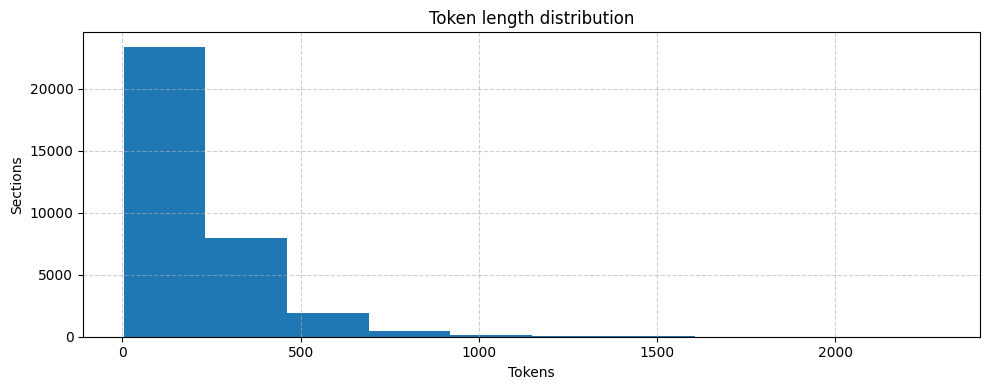

In [17]:
## Histogramme de la longueur des textes
def plot_histogram(dataframe, column, title, xlabel, ylabel, bins=50):
    plt.figure(figsize=(10, 4))
    dataframe[column].hist(bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_histogram(
    df,
    'text_token_length',
    'Token length distribution',
    'Tokens',
    'Sections',
     bins=10
)


Another issue with dataset is that some sections are very long (more than 1000 tokens).

These sections may exceed the input limit of some embedding models we want to apply later.

Let's take a closer look.

In [8]:
camembert_base_max_length = SentenceTransformer('Lajavaness/sentence-camembert-base').max_seq_length
camembert_large_max_length = SentenceTransformer('Lajavaness/sentence-camembert-large').max_seq_length
multilingual_max_length = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1').max_seq_length


print(f"CamemBERT base max length: {camembert_base_max_length}")
print(f"CamemBERT large max length: {camembert_large_max_length}")
print(f"Multilingual base max length: {multilingual_max_length}")

CamemBERT base max length: 128
CamemBERT large max length: 514
Multilingual base max length: 128


To prevent this limitation, we will apply a custom chunking strategy that will split the text into smaller chunks while preserving the context of each section.

## Chunking method

It exists many ways to split a text into chunks (characters, sentences, paragraphs, etc.): There is no universal method, but you have to choose the method that is most suitable for your use case.

Two parameters are important to consider:
- `CHUNK_SIZE`: the maximum size of the chunks in tokens (e.g. 512 tokens for CamemBERT) ;
- `CHUNK_OVERLAP`: the number of tokens that overlap between chunks (e.g. 10% of the chunk size, i.e. 51 tokens for a chunk of 512 tokens).

Ici on utilise une stratégie de double chunking :

- Le premier découpage est déjà effectué via le scraping par section (découpage sémantique) Cf.supra.
- Le second est un découpage par tokens, car les modèles d'embedding ont une limite fixe d'entrée (ex: 514 tokens).
- Chaque chunk est enrichi avec le titre de la section pour donner du contexte (ex: "Introduction : le ...").

> we using RecursiveCharacterTextSplitter from langchain to split the text into chunks, this not chunking by characters but by tokens because we explicitly use "from_huggingface_tokenizer" method (Check doc: https://python.langchain.com/docs/how_to/split_by_token/#hugging-face-tokenizer).

In [9]:
CHUNK_SIZE = config['chunking']['chunk_size']

# Compute the chunk overlap as 10% of the chunk size. This allows to dynamically define the chunk overlap to avoid size errors.
CHUNK_OVERLAP =  int(CHUNK_SIZE / 10)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("Lajavaness/sentence-camembert-large", use_fast=True)

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True,
    strip_whitespace=True,
)

In [11]:
def count_tokens(text: str) -> int:
    """Returns the number of tokens in the text, including special tokens.

    Args:
        text (str): The input text to tokenize.

    Returns:
        int: The number of tokens in the text.
    """
    return len(tokenizer(text, add_special_tokens=True)['input_ids'])

def clean_text(text: str) -> str:
    """Clean text by: removing extra spaces, normalizing unicode characters.

    Args:
        text (str): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    return unicodedata.normalize("NFKC", " ".join(text.strip().split()))

def remove_special_tokens_ids(token_ids: list[int]) -> list[int]:
    """Delete special tokens from a list of token IDs.

    Args:
        token_ids (list[int]): List of token IDs to clean.

    Returns:
        list[int]: List of token IDs without special tokens.
    """
    special_ids = tokenizer.all_special_ids
    return [tok for tok in token_ids if tok not in special_ids]

def process_row_recursive(row: pd.Series) -> list[dict]:
    """Apply the chunking at token level on a DataFrame row:
    - Cleans the text and adds the title as a prefix.
    - Splits the text into fixed-size chunks (special tokens included).
    - Saves the chunk WITHOUT special tokens (for human use / display).

    Args:
        row (pd.Series): A row of the DataFrame containing the text and metadata.

    Returns:
        list[dict]: A list of dictionaries, each containing the chunk information.
    """
    text = clean_text(row[TEXT_COL])
    title = f"{clean_text(row['position_name'])} : "
    len_title = count_tokens(title)

    chunks = text_splitter.split_text(text)
    results = []

    for i, chunk in enumerate(chunks):
        chunk_token_ids = tokenizer(chunk, add_special_tokens=True)["input_ids"]
        total_tokens = len_title + len(chunk_token_ids)

        # Truncating the chunk if it exceeds the maximum allowed size
        if total_tokens > CHUNK_SIZE:
            allowed = CHUNK_SIZE - len_title
            chunk_token_ids = chunk_token_ids[:allowed]


        # Chunk clean: remove special tokens for saving
        chunk_token_ids_clean = remove_special_tokens_ids(chunk_token_ids)
        chunk_text = tokenizer.decode(chunk_token_ids_clean, skip_special_tokens=True)

        # Texte complet avec titre + chunk nettoyé
        full_chunk = f"{title}{chunk_text}".strip()

        results.append({
            "unique_id": row["unique_id"],
            "chunk_id": f"{row['unique_id']}_chunk_{i}",
            "file_id": row.get("file_id"),
            "author": row.get("author"),
            "position_name": clean_text(row.get("position_name")),
            "year": row.get("year"),
            "section": row.get("section"),
            "raw_chunk": chunk_text,
            "full_chunk": full_chunk,
            "full_chunk_characters_len": len(full_chunk),
            "full_chunk_token_len": count_tokens(full_chunk),  # avec tokens spéciaux inclus
        })

    return results


In [12]:
# Apply chunking to the DataFrame and save the results.
out_path = get_absolute_path(f"data/raw/encpos_chunked_tok_{CHUNK_SIZE}_{CHUNK_OVERLAP}.csv")
if os.path.exists(out_path):
    print(f"⚠️ File already generated : {out_path}. Delete it to rebuild.")
    df_chunks = pd.read_csv(out_path, sep="\t")
else:
    # chunking accelerated by parallel processing
    results = Parallel(n_jobs=-1)(
        delayed(process_row_recursive)(row) for _, row in tqdm(df.iterrows(), total=len(df))
    )
    flat_chunks = [item for sublist in results for item in sublist]
    # chunks dedupe (just in case)
    df_chunks = pd.DataFrame(flat_chunks).drop_duplicates(subset=["full_chunk", "unique_id"]).reset_index(drop=True)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df_chunks.to_csv(out_path, sep="\t", encoding="utf-8", index=False)

⚠️ File already generated : /Users/lucaterre/Documents/pro/Travail_courant/DEV/AI-ENC-Projects/on-github/encpos-qa-rag/data/raw/encpos_chunked_tok_512_51.csv. Delete it to rebuild.


## Post-chunking analysis

In [13]:
## Statistiques des chunks
print("Total chunks generated:", len(df_chunks))
max_chunk_token_length = df_chunks['full_chunk_token_len'].max()
min_chunk_token_length = df_chunks['full_chunk_token_len'].min()
mean_chunk_token_length = df_chunks['full_chunk_token_len'].mean()
print("Max token length:", int(max_chunk_token_length))
print("Min token length:", int(min_chunk_token_length))
print("Mean token length:", int(mean_chunk_token_length))

Total chunks generated: 39377
Max token length: 511
Min token length: 14
Mean token length: 265


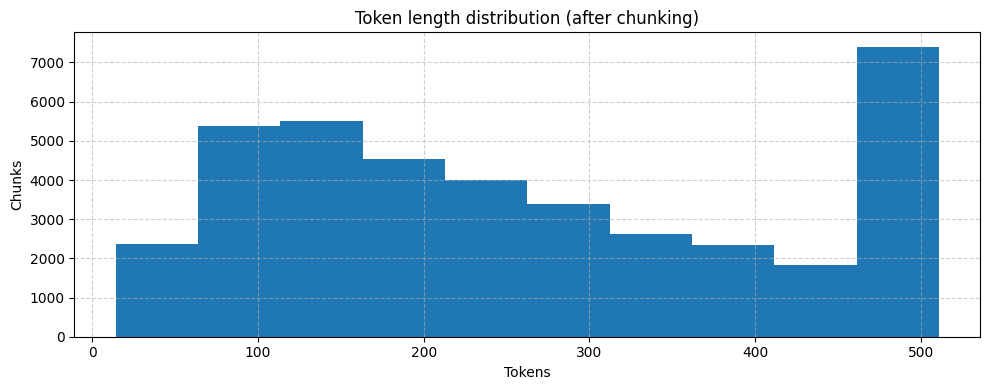

In [16]:
## Histogramme après découpe
plot_histogram(
    df_chunks,
    'full_chunk_token_len',
    'Token length distribution (after chunking)',
    'Tokens',
    'Chunks',
    bins=10
)

- The chunking strategy is effective, with a good balance between chunk size and overlap.
- The maximum chunk length (512) is within the limits of the most embedding models.
- The total number of chunks is sufficient for vector indexing.


➡️ Notebook suivant : [02-build_vectordb.ipynb](./02-build_vectordb.ipynb)